## Introduction

In [1]:
# for everything else
import os
import random
import scipy

from functools import partial
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from imageio import imread
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
import pickle
# from keras.layers import Activation, Dense, Dropout

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# clustering and dimension reduction
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
# import hdbscan

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from tqdm import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

from sklearn.metrics import plot_confusion_matrix
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
random.seed(10)
np.random.seed(10)

In [3]:
config = {
    'method': 'AgglomerativeClustering',
    'n_neighbors': 60,
    'min_dist': 0.15,
    'n_components': 2,
    'n_clusters': 4,
    'n_init': 10,
    'random_state': 42
}

## Load Data

In [4]:
base_dir = '../input/nbiinfframes/FRAMES'
Fold1 = '../input/nbiinfframes/FRAMES/Fold1'
Fold2 = '../input/nbiinfframes/FRAMES/Fold2'
Fold3 = '../input/nbiinfframes/FRAMES/Fold3'

pkl_file = r"../input/feature-embedding/files_feature_embeddings_vgg16.pkl"

class_ = ['B', 'I', 'S', 'U']

Folds = [Fold1, Fold2, Fold3]
all_data = []

# Define path to the data directory
for fold in Folds:
    for case in class_:
        path = os.path.join(fold, case)
        if os.path.isdir(path):
            for img in os.listdir(path):
                all_data.append([os.path.join(path, img), case, os.path.basename(fold)])
        
all_df = pd.DataFrame(all_data, columns=['image_path', 'class', 'folder'],index=None)
all_df.dropna(inplace = True)

all_df['name'] = all_df['image_path'].map(lambda x: os.path.basename(x))
img_name = all_df['name'] .to_list()
files = all_df['image_path'].to_list()

In [5]:
all_df.head()

,image_path,class,folder,name
0,../input/nbiinfframes/FRAMES/Fold1/B/mvideo28_...,B,Fold1,mvideo28_03796.jpg
1,../input/nbiinfframes/FRAMES/Fold1/B/mvideo28_...,B,Fold1,mvideo28_04694.jpg
2,../input/nbiinfframes/FRAMES/Fold1/B/mvideo28_...,B,Fold1,mvideo28_04039.jpg
3,../input/nbiinfframes/FRAMES/Fold1/B/video8_02...,B,Fold1,video8_02675.jpg
4,../input/nbiinfframes/FRAMES/Fold1/B/mvideo28_...,B,Fold1,mvideo28_04040.jpg


## Display

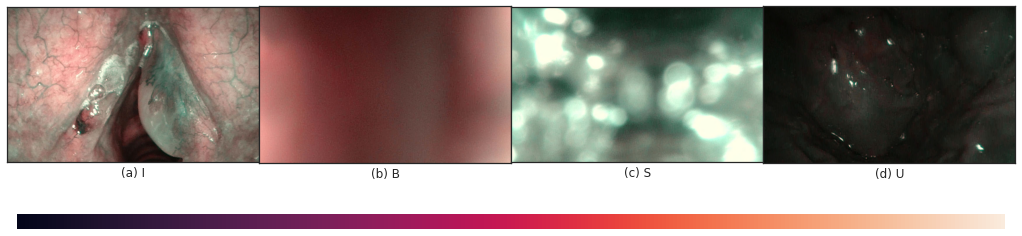

In [6]:
image_example = [all_df.loc[all_df['class']== 'I']['image_path'].iloc[15],
                all_df.loc[all_df['class']== 'B']['image_path'].iloc[15],
                all_df.loc[all_df['class']== 'S']['image_path'].iloc[30],
                all_df.loc[all_df['class']== 'U']['image_path'].iloc[15]]

fig, axs = plt.subplots(1, 4, constrained_layout=True)
pcm = [i for i in range(4)]
for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel(['(a){}', '(b){}', '(c){}', '(d){}'][i].format([' I', ' B', ' S', ' U'][i]))
    pcm = axs[i].imshow(imread(image_example[i]))
    
plt.tight_layout()
cbar = fig.colorbar(pcm, 
                    ax=axs[-1:], 
#                     shrink=1.5, 
                    cax = fig.add_axes([0.01, 0.3, 0.98, 0.02]), ticks=[], orientation='horizontal') #shrink=1.0, #location='bottom',  orientation='horizontal' #fraction=0.19, aspect=15

## remove white margin
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("dataset_overview.pdf", bbox_inches = 'tight',pad_inches = 0)

plt.show()

## Methods: Building Model

In [7]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
out_features = model.output.shape[1] # to obtain the number of the output feature

2022-04-26 05:19:33.498180: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


553476096/553467096 [==============================] - 3s 0us/step


In [8]:
files[0],  os.path.basename(files[0])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Feature Extraction by CNN

In [9]:
def extract_features(files, model, pkl="", out_feature=out_features):
    
    data = {}
    if os.path.exists(pkl):
        with open(pkl, 'rb') as f:
            data = pickle.load(f)
    else:
        print("File data pkl file doesn't exist..., extracting by model")
        for file in files:
            resized_img = load_img(file, target_size=(224,224)) ##reshaped
            img_arr = np.array(resized_img) 
            reshaped_img = img_arr.reshape(1,224,224,3)  ##reshape
            imgx = preprocess_input(reshaped_img)
            embeddings = model.predict(imgx, use_multiprocessing=True)
            data[os.path.basename(file)] = embeddings
            
        pickle.dump(data, open(pkl, "wb"))
 
    filenames = np.array(list(data.keys()))
    feat = np.array(list(data.values()))
    feat = feat.reshape(-1, out_features)

    return filenames, feat

In [10]:
%%time

filenames, feat = extract_features(files, model, pkl_file, out_features)    
print('extracted feature shape: {}'.format(feat.shape))

extracted feature shape: (720, 4096)
CPU times: user 18 ms, sys: 13.8 ms, total: 31.7 ms
Wall time: 254 ms


## Clustering

In [11]:
def generate_mkmclusters(feature_embeddings,
                       n_neighbors = 190,
                       min_dist = 0.25,
                       metric='manhattan',
                       n_components = 2,
                       n_clusters = 4,
                       n_init = 10,
                       random_state = 42,
                       batch_size = 512):
    
    umap_embeddings = umap.UMAP(n_neighbors = n_neighbors,
                                min_dist = min_dist,
                                n_components = n_components,
                                metric = metric,
                                random_state=random_state).fit_transform(feature_embeddings)
    
    clusters = MiniBatchKMeans(init="k-means++",
                          n_clusters = n_clusters,
                          batch_size = batch_size,
                          max_iter=400,
                          n_init = n_init,
                          max_no_improvement=10,
                          verbose=0,
                          random_state=random_state).fit(umap_embeddings)
    
    return clusters

In [12]:
def generate_speclusters(feature_embeddings,
                       n_neighbors = 260,
                       min_dist = 0.0,
                       metric = 'manhattan',
                       eigen_solver = 'arpack',
                       affinity = 'rbf',
                       assign_labels = 'kmeans',
                       random_state = 42,
                       n_components = 2,
                       n_clusters = 4,
                       n_init = 10):
        
    umap_embeddings = umap.UMAP(n_neighbors = n_neighbors,
                                min_dist = min_dist,
                                n_components = n_components,
                                metric = metric,
                                random_state=random_state).fit_transform(feature_embeddings)
    
    clusters = SpectralClustering(n_clusters = n_clusters,
                                  n_components = n_components,
                                  n_init = n_init,
                                  eigen_solver = eigen_solver,
                                  affinity = affinity,
                                  assign_labels = assign_labels,
                                  gamma=1.0,
                                  n_jobs=None, 
                                  n_neighbors=10,
                                  random_state=random_state).fit(umap_embeddings) #tsne_sc_s

    return clusters

In [13]:
def generate_aggclusters(feature_embeddings,
                       n_neighbors = 60,
                       min_dist = 0.15000000000000002,
                       metric = 'hellinger',
                       affinity = 'euclidean',
                       linkage = 'ward',
                       random_state = 42,
                       n_components = 2,
                       n_clusters = 4,
                       n_init = 10):
        
    umap_embeddings = umap.UMAP(n_neighbors = n_neighbors,
                                min_dist = min_dist,
                                n_components = n_components,
                                metric = metric,
                                random_state=random_state).fit_transform(feature_embeddings)
    
    clusters = AgglomerativeClustering(n_clusters=n_clusters,
                                       affinity=affinity,
                                       linkage=linkage,
                                       memory=None,
                                       connectivity=None,
                                       compute_full_tree='auto',
                                       distance_threshold=None, 
                                       compute_distances=False).fit(umap_embeddings) 
    
    return clusters

{'dbscan_metric': 'l2', 'eps': 0.6001000000000001, 'min_dist': 0.0, 'min_samples': 15, 'n_neighbors': 120, 'umap_metric': 'correlation'}

1️⃣ UMAP, n_neighbors: 80, min_dist: 0.0, umap_metric: hellinger

2️⃣ DBSCAN, eps: 0.7000000000000002, min_samples: 15, dbscan_metric:l2, algorithm: auto

3️⃣ LABLE&COUNTS: {0: 203, 1: 143, 2: 217, 3: 157}

4️⃣ LOSS: out_counts: 0, label_dev: 0, cluster_var: 949.0, total: 9.49

In [14]:
def generate_hdbclusters(feature_embeddings,
                       random_state = config['random_state'],
                       n_components = config['n_components']):
    

    umap_embeddings = umap.UMAP(n_neighbors = 80,
                                min_dist = 0.0,
                                n_components = n_components,
                                metric = 'hellinger',
                                random_state=random_state).fit_transform(feature_embeddings)
    
    clusters = DBSCAN(eps=0.7000000000000002,
                      min_samples = 15,
                      metric = 'l2').fit(umap_embeddings) #algorithm = algorithm
    
    return clusters

In [15]:
def auto_labeling(gt_df, clustered_df, class_ = ['B', 'I', 'S', 'U']):
    target2label = {}
    
    g1 = clustered_df.groupby('clustered_target')['name']
    g2 = gt_df.groupby('class')['name']
    
    for n in list(g1.groups.keys()):
        group_ins_num = [len(set(g1.get_group(n)) & set(g2.get_group(label))) for label in list(g2.groups.keys())]
        target2label[n] = class_[group_ins_num.index(max(group_ins_num))]
        print('the group {} intersect with {} is {}, the likely label is {}'.format(n, g2.groups.keys(),group_ins_num, target2label[n]))

    return target2label

In [16]:
clusters = generate_hdbclusters(feat)
clustered_target = clusters.labels_ #group id generated from cluster
clustered_df = pd.DataFrame({'name':filenames, 'clustered_target':clustered_target})

clustered_df = clustered_df[clustered_df['clustered_target'] != -1] # for the dbscan

target2label = auto_labeling(all_df, clustered_df, class_)

clustered_df['predict_class'] = clustered_df['clustered_target'].map(target2label)
eval_df = pd.merge(clustered_df, all_df, on='name', how='left')


clustered_df.shape[0]

eval_df

df = pd.DataFrame({'y_Actual': eval_df['class'], 
                   'y_Predicted': eval_df['predict_class']},
                  columns=['y_Actual','y_Predicted'])


df

the group 0 intersect with dict_keys(['B', 'I', 'S', 'U']) is [178, 0, 23, 2], the likely label is B
the group 1 intersect with dict_keys(['B', 'I', 'S', 'U']) is [0, 142, 1, 0], the likely label is I
the group 2 intersect with dict_keys(['B', 'I', 'S', 'U']) is [2, 38, 0, 177], the likely label is U
the group 3 intersect with dict_keys(['B', 'I', 'S', 'U']) is [0, 0, 156, 1], the likely label is S


,y_Actual,y_Predicted
0,B,B
1,B,B
2,B,B
3,B,B
4,B,B
...,...,...
715,U,U
716,U,U
717,U,U
718,U,U


In [17]:
def evalue_score_(clusters, filenames, df, class_):
    clustered_target = clusters.labels_ #group id generated from cluster
    clustered_df = pd.DataFrame({'name':filenames, 'clustered_target':clustered_target})
    clustered_df = clustered_df[clustered_df['clustered_target'] != -1] # for the dbscan
    
    target2label = auto_labeling(df, clustered_df, class_)

    clustered_df['predict_class'] = clustered_df['clustered_target'].map(target2label)
    eval_df = pd.merge(clustered_df, df, on='name', how='left')
    
    df = pd.DataFrame({'y_Actual': eval_df['class'], 
                   'y_Predicted': eval_df['predict_class']},
                  columns=['y_Actual','y_Predicted'])
    
    return df

In [18]:
def prf_report(df, method = config['method'], results = []):

    y_test = df['y_Actual']
    y_pred = df['y_Predicted']
    
    report = classification_report(y_test, y_pred)
    print('------------- classification report of {} ------------- '.format(method))
    print(report)
    print('------------------------ End ----------------------------')
    
    precision_score_ = precision_recall_fscore_support(y_test, y_pred)[0]
    recall_score_ = precision_recall_fscore_support(y_test, y_pred)[1]
    f1_score_ = precision_recall_fscore_support(y_test, y_pred)[2]

    avg_precision = np.average(precision_score_)
    avg_recall = np.average(recall_score_)
    avg_f1 = np.average(f1_score_)
    
    results.append([method, precision_score_, recall_score_, f1_score_])

    return results

In [19]:
def cm_plot(confusion_matrix, method):
    group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.to_numpy().flatten()]
    group_percentages = ["{0:.2f}".format(value) for value in (confusion_matrix/np.sum(confusion_matrix)).to_numpy().flatten()]
    labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(4,4)
    ax = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.title('the Confusion Maxtrix of the {}'.format(config['method']))
    plt.savefig('{}_confusion_matrix.png'.format(method))
    return ax

In [20]:
results = []
methods = ['MinibatchKMeans', 'Agglomerative', 'Spectral', 'DBSCAN']

for method in methods:
    if method == 'MinibatchKMeans':
        clusters = generate_mkmclusters(feat)
    elif method == 'Agglomerative':
        clusters = generate_aggclusters(feat)
    elif method == 'Spectral':
        clusters = generate_speclusters(feat)
    elif method == 'DBSCAN':
        clusters = generate_hdbclusters(feat)
        
    df = evalue_score_(clusters, filenames, all_df, class_)
    prf_report(df, method, results)
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)

#     for cm, ax in zip(confusion_matrix, axs):
#         cm_img  = cm_plot(confusion_matrix, method)
#         ax.set_axis_off()
#         ax.imshow(cm_img)

the group 0 intersect with dict_keys(['B', 'I', 'S', 'U']) is [2, 12, 7, 167], the likely label is U
the group 1 intersect with dict_keys(['B', 'I', 'S', 'U']) is [0, 168, 0, 0], the likely label is I
the group 2 intersect with dict_keys(['B', 'I', 'S', 'U']) is [177, 0, 19, 2], the likely label is B
the group 3 intersect with dict_keys(['B', 'I', 'S', 'U']) is [1, 0, 154, 11], the likely label is S
------------- classification report of MinibatchKMeans ------------- 
              precision    recall  f1-score   support

           B       0.89      0.98      0.94       180
           I       1.00      0.93      0.97       180
           S       0.93      0.86      0.89       180
           U       0.89      0.93      0.91       180

    accuracy                           0.93       720
   macro avg       0.93      0.93      0.92       720
weighted avg       0.93      0.93      0.92       720

------------------------ End ----------------------------
Predicted    B    I    S    U
Actu

In [21]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# for cls, ax in zip(classifiers, axes.flatten()):
#     plot_confusion_matrix(cls, 
#                           X_test, 
#                           y_test, 
#                           ax=ax, 
#                           cmap='Blues',
#                          display_labels=data.target_names)
#     ax.title.set_text(type(cls).__name__)
# plt.tight_layout()  
# plt.show()

In [22]:
def draw_confusionx(df, method):
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.to_numpy().flatten()]
    group_percentages = ["{0:.2f}".format(value) for value in (confusion_matrix/np.sum(confusion_matrix)).to_numpy().flatten()]
    labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(4,4)
    ax = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
#     plt.title('the Confusion Maxtrix of the {}'.format(config['method']))
    plt.savefig('{}_confusion_matrix.png'.format(method))
    return plt

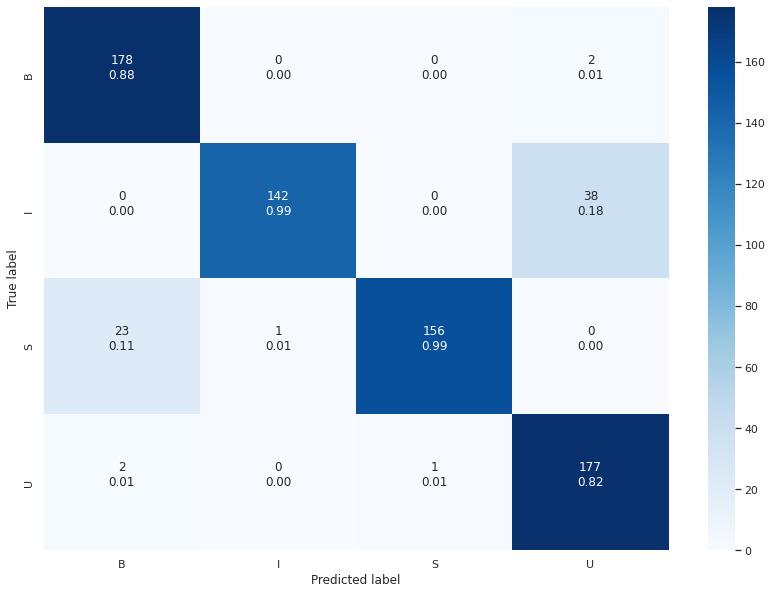

In [23]:
plt = draw_confusionx(df, 'MinibatchKMeans')
plt.show()

In [24]:
result_df = pd.DataFrame(results, columns=['method', 'precision', 'recall', 'f1'])
result_df

,method,precision,recall,f1
0,MinibatchKMeans,"[0.8939393939393939, 1.0, 0.927710843373494, 0...","[0.9833333333333333, 0.9333333333333333, 0.855...","[0.9365079365079364, 0.9655172413793104, 0.890..."
1,Agglomerative,"[0.8894472361809045, 0.9883720930232558, 0.987...","[0.9833333333333333, 0.9444444444444444, 0.888...","[0.9340369393139842, 0.9659090909090908, 0.935..."
2,Spectral,"[0.885, 0.9941176470588236, 0.9216867469879518...","[0.9833333333333333, 0.9388888888888889, 0.85,...","[0.9315789473684211, 0.9657142857142857, 0.884..."
3,DBSCAN,"[0.8768472906403941, 0.993006993006993, 0.9936...","[0.9888888888888889, 0.7888888888888889, 0.866...","[0.9295039164490861, 0.8792569659442725, 0.925..."


#### [x]TODO clouds of the image name 

### Draw Confusion mx

In [25]:
def draw_roc_auc(df, method = config['method']):
    # # Compute ROC curve and ROC area for each class

    le = LabelEncoder()
    df['y_Actual_enc']= le.fit_transform(df['y_Actual'])
    df['y_Predicted_enc']= le.fit_transform(df['y_Predicted'])
    y_test = to_categorical(df['y_Actual_enc'], num_classes = len(le.classes_),dtype='int64')
    y_pred = to_categorical(df['y_Predicted_enc'], num_classes = len(le.classes_),dtype='int64')
    le.classes_, le.classes_[0]

    fpr = dict()
    tpr = dict()

    roc_auc = dict()
    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (AUC = {0:0.2f})'
                ''.format(roc_auc["micro"]))
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:0.2f})'
                                    ''.format(le.classes_[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC/AUC of the {}'.format(method))
    plt.legend(loc="lower right")
    plt.savefig('{}_roc_curve.png'.format(method))
    plt.show()

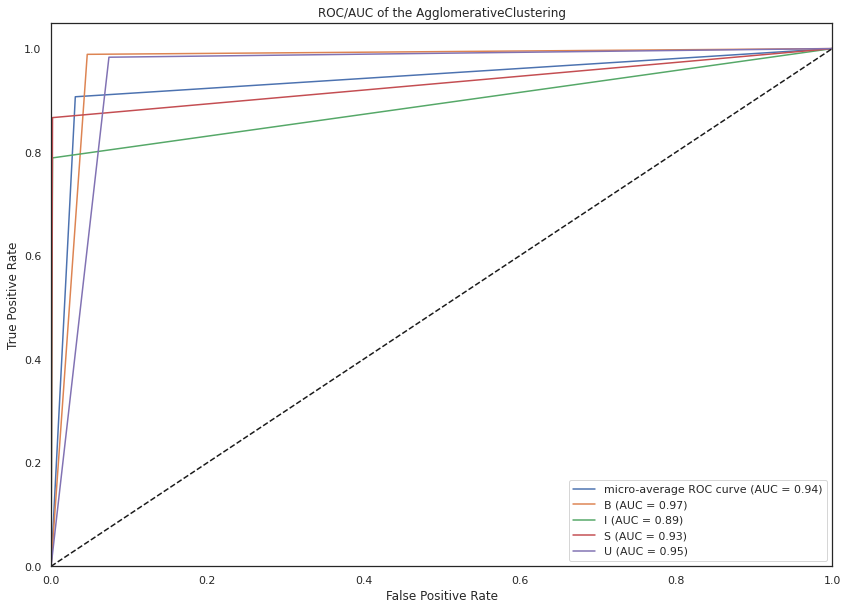

In [26]:
draw_roc_auc(df)

## Boxplot Recall

In [27]:
result_df.T

,0,1,2,3
method,MinibatchKMeans,Agglomerative,Spectral,DBSCAN
precision,"[0.8939393939393939, 1.0, 0.927710843373494, 0...","[0.8894472361809045, 0.9883720930232558, 0.987...","[0.885, 0.9941176470588236, 0.9216867469879518...","[0.8768472906403941, 0.993006993006993, 0.9936..."
recall,"[0.9833333333333333, 0.9333333333333333, 0.855...","[0.9833333333333333, 0.9444444444444444, 0.888...","[0.9833333333333333, 0.9388888888888889, 0.85,...","[0.9888888888888889, 0.7888888888888889, 0.866..."
f1,"[0.9365079365079364, 0.9655172413793104, 0.890...","[0.9340369393139842, 0.9659090909090908, 0.935...","[0.9315789473684211, 0.9657142857142857, 0.884...","[0.9295039164490861, 0.8792569659442725, 0.925..."


In [28]:
def extract_recall(result_df):
    ## SOTA
    recall_results = []

    recall_results.append(['Moccia, 2018', 0.83, 0.91, 0.62, 0.85])
    recall_results.append(['Galdran, 2019', 0.94, 1, 0.91, 0.94])
    recall_results.append(['Patrini, 2020', 0.96,0.97,0.88,0.93])
    
    for i in range(result_df.shape[0]):
        eval_method = []
        eval_method.extend([result_df['method'].astype('str').iloc[i]])
        eval_method.extend(result_df['recall'].iloc[i].tolist())
        recall_results.append(eval_method)

    recall_df = pd.DataFrame(np.array(recall_results), columns=['method', 'B', 'I', 'S', 'U'])
    data = recall_df.iloc[:,1:].T.to_numpy().astype('float')
    labels = recall_df.T.iloc[0].astype('str').tolist()
    return data, labels

In [29]:
data, labels = extract_recall(result_df)

In [30]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
tips = sns.load_dataset("tips")

def boxplot_classic(data, labels):
    # data = np.random.lognormal(size=(37, 4))
    fig, ax1 = plt.subplots()

    boxprops = dict(linewidth=3,  color='blue')
    medianprops = dict(linewidth=3, color='red')
    whiskerprops = dict(linewidth=3, color='black')
    capprops = dict(linewidth=3, color='black')
    
    with plt.style.context('classic'):
        ax1.boxplot(data, showfliers=False,
                    boxprops = boxprops,
                    labels = labels, 
                    medianprops = medianprops,
                    whiskerprops = whiskerprops,
                    capprops=capprops)
        
        ax1.set_title('Recall Comparison of Different methods')
        ax1.set_xlabel('methods', fontweight ='bold')
        ax1.set_ylabel('recall', fontweight ='bold')
        ax1.grid(True, linestyle='-.')

        ax1.tick_params(direction='in',
                        length=6,
                        width=2,
                        colors='black',
                        labelsize='small', #medium, large
                        grid_color='grey',
                        grid_alpha=0.5)
        
    fig.savefig("boxplot.pdf", bbox_inches = 'tight',pad_inches = 0)
    fig.show()

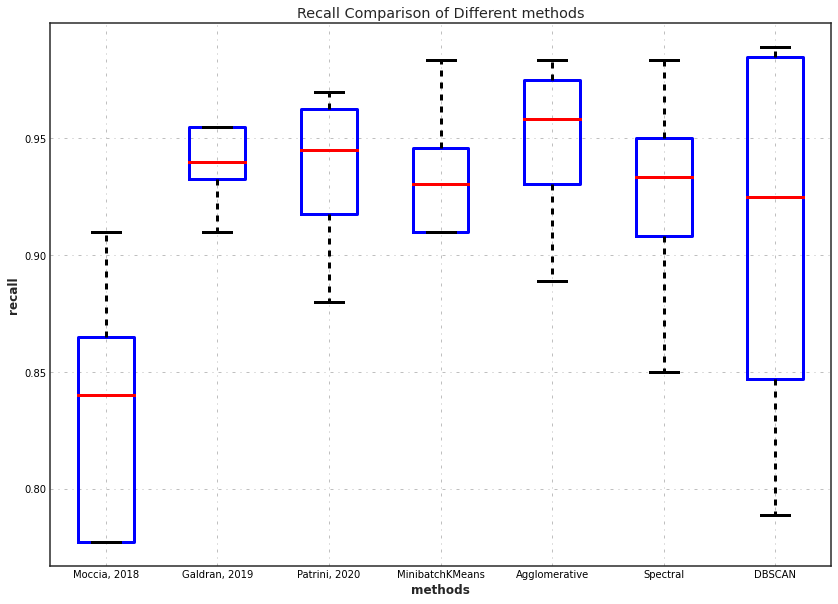

In [31]:
boxplot_classic(data, labels)

In [32]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [33]:
data[:,4]

array([0.98333333, 0.94444444, 0.88888889, 0.97222222])

In [34]:
from scipy.stats import mannwhitneyu

#only compare with Moccia, 2018

pvalues = []
for x in range(3):
#     stat, pvalue = scipy.stats.ttest_ind(data[:,x].tolist(), data[:,3].tolist())
    s, p = mannwhitneyu(data[:,x].tolist(), data[:,4].tolist())
    pvalues.append(p)
    print(convert_pvalue_to_asterisks(p))
pvalues

ns
ns
ns


[0.05714285714285714, 0.8845494388529623, 0.4857142857142857]

In [35]:
from scipy.stats import wilcoxon

data1 = data[:,0].tolist()
data2 = data[:,4].tolist()
# stat, pvalue = scipy.stats.ttest_ind(data1, data2)
# stat, pvalue = mannwhitneyu(data1, data2)
stat, pvalue = wilcoxon(data1, data2)

print('Statistics=%.3f, p=%.3f' % (stat, pvalue))

alpha = 0.05
if pvalue > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')


convert_pvalue_to_asterisks(pvalue)


Statistics=0.000, p=0.125
Same distribution (fail to reject H0)


'ns'